In [1]:
%matplotlib inline

In [10]:
# This notebook delineates catchments for LamaH-Ice.
# It uses the pysheds package and a 20x20m DEM (IslandsDEM)

In [90]:
import rasterio
from rasterio.plot import show_hist, show
from rasterio.mask import mask
from shapely.geometry import box, mapping, Polygon
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import matplotlib.pyplot as plt
from pysheds.grid import Grid
import numpy as np
import pyproj
import rasterio as rio
from rasterio import plot, mask
import contextily as ctx
import os
from matplotlib_scalebar.scalebar import ScaleBar
import pickle
import fiona
import pandas as pds

# Read DEM

In [59]:
# DEM (grid) is full iceland in the coordinate projection ISN93
dem_path = '../data/dem/IslandsDEMv1.0_20x20m_isn93_zmasl.tif'
# dem_path = '/data/helgason/camels-ice/dem/IslandsDEMv1.0_20x20m_isn93_zmasl.tif'
grid = Grid.from_raster(dem_path,data_name='dem')
dem = grid.read_raster(dem_path)

# Condition DEM

In [5]:
# We start by filling pits, depressions and resolve flats in the DEM

# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem,max_iter=1e9,eps=1e-12)

# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

In [78]:
# Uncomment the following if needed to save the output from the DEM conditioning
# We now pickle the grid object and the output from the steps above so we can access it later
# grid_dict = dict()
# grid_dict['grid'] = grid
# grid_dict['pit_filled_dem'] = pit_filled_dem
# grid_dict['flooded_dem'] = flooded_dem
# grid_dict['inflated_dem'] = inflated_dem
# grid_dict['fdir'] = fdir
# grid_dict['acc'] = acc
# dict_save_path = '../data/dem/20x20_ISN93_conditioning_output.p'
# pickle.dump( grid_dict, open( dict_save_path, "wb" ) )

# # Save just the grid (we'll only need to reload the grid in the loop later on)
# pickle.dump( grid, open( "../data/dem/20x20_ISN93_conditioning_output_grid.p", "wb" ) )

# Load the dictionary back from the pickle file.
grid_dict_loaded = pickle.load( open( dict_save_path, "rb" ) )
acc = grid_dict_loaded['acc']

# Read gauge coordinates

In [16]:
combined_gauges_path = '../gauge_shapefiles/gauges_combined.shp'
combined_gauges = gpd.read_file(combined_gauges_path)
combined_gauges = combined_gauges.set_index('obj_id')

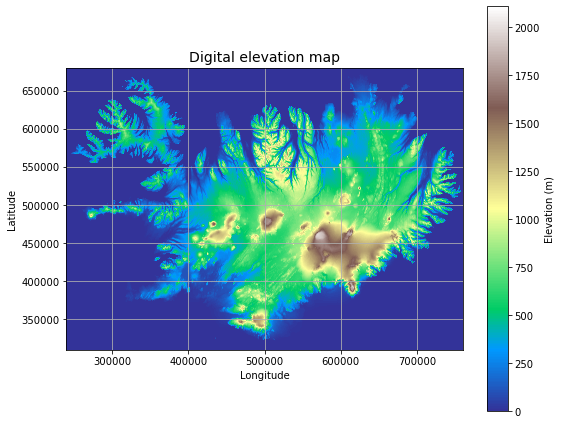

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1,vmin=0)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

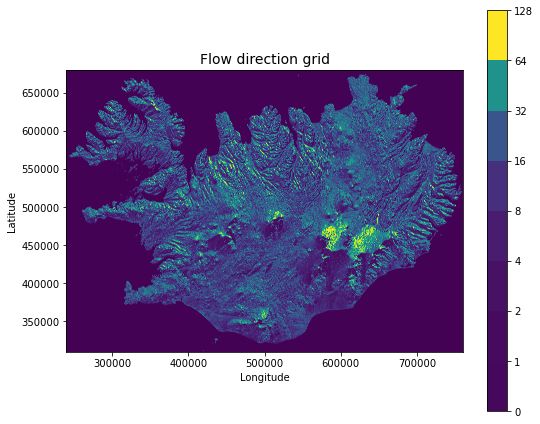

In [45]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

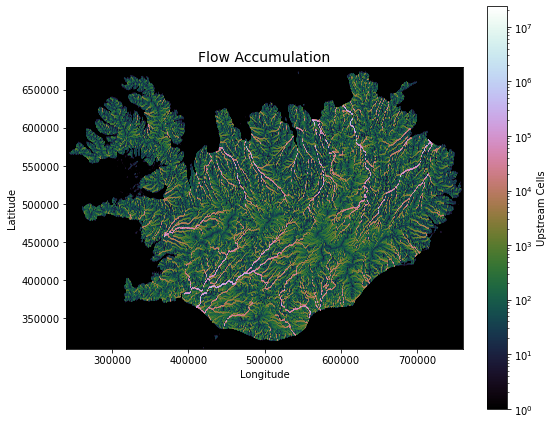

In [44]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

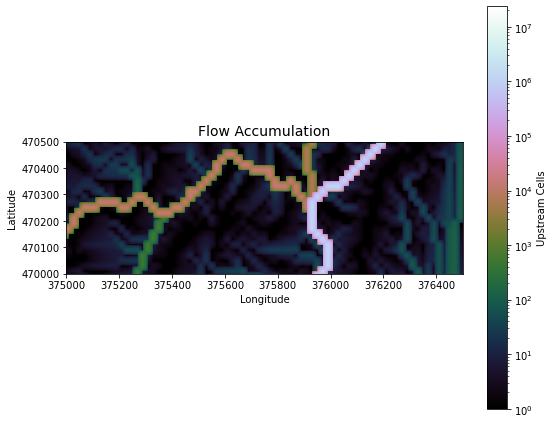

In [101]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([375000,376500])
plt.ylim([470000, 470500])
plt.tight_layout()

In [103]:
combined_gauges.loc[idx]['st_numer']

gid                                                   NaN
st_numer                                               NA
st_nafn                                 Karahnjukastifla7
vhm_numer                                             NaN
vatnsfall                                            None
flokkur                                              None
tegund                                               None
gagnaeigan                                           None
vod_svaedi                                            NaN
vod_nafn                                             None
stada                                                None
upphaf_rek                                           None
dags_aflag                                           None
x                                                     NaN
y                                                     NaN
f16                                                  None
geometry      POINT (651721.9192799167 498258.0673817196)
Name: 2016.0, 

# Delineate watersheds

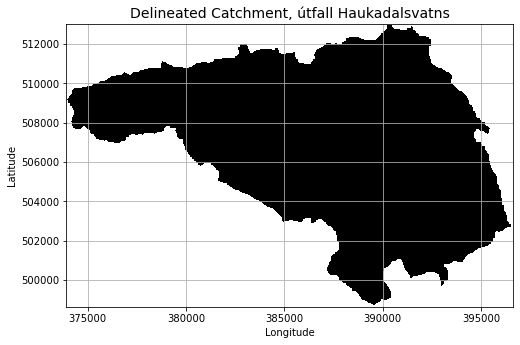

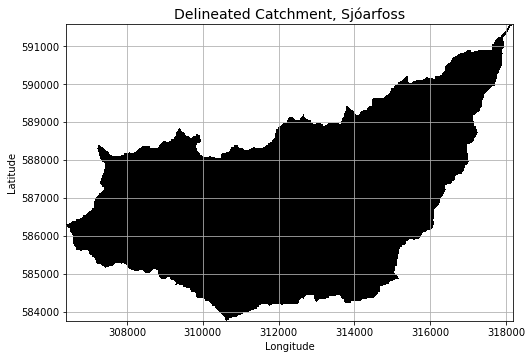

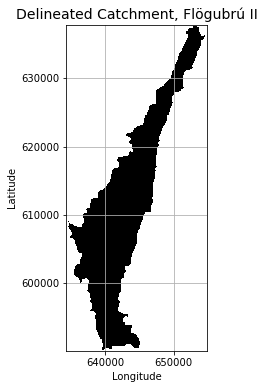

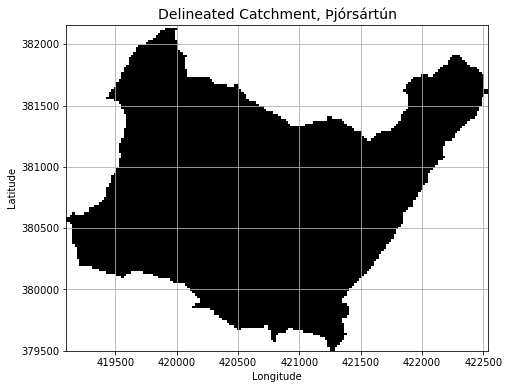

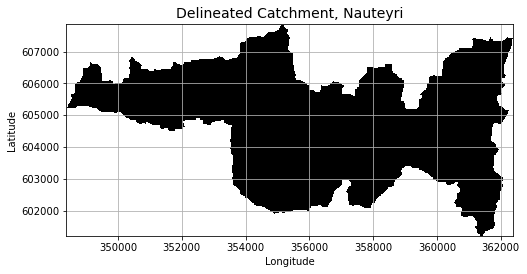

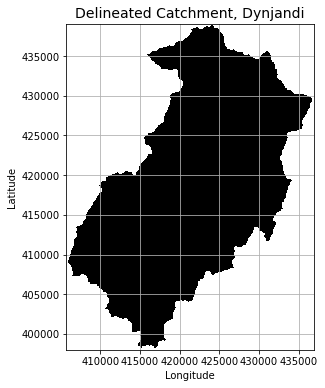

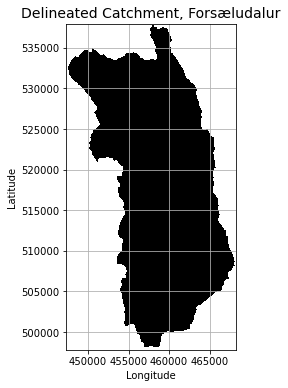

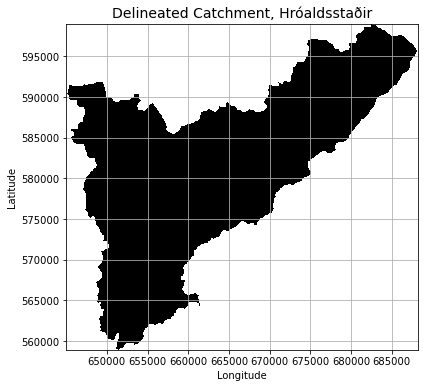

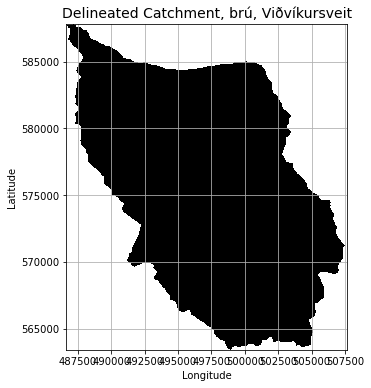

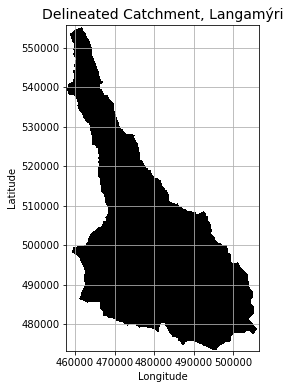

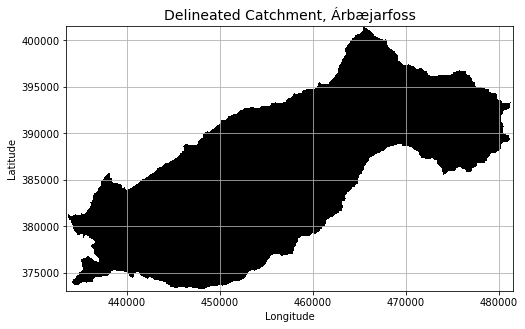

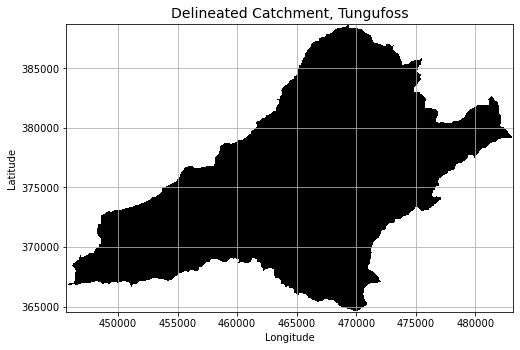

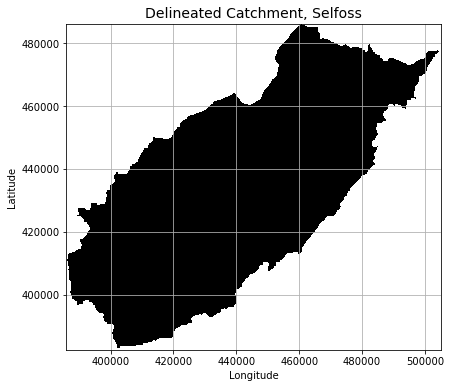

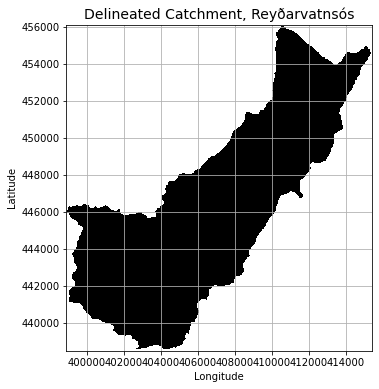

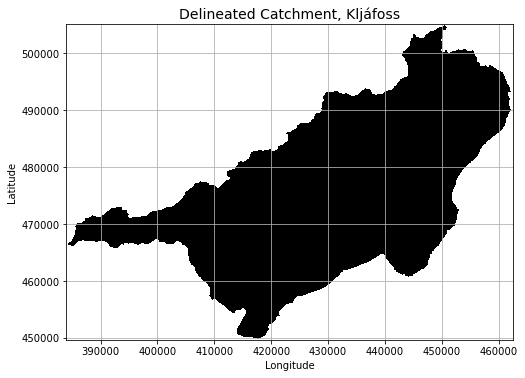

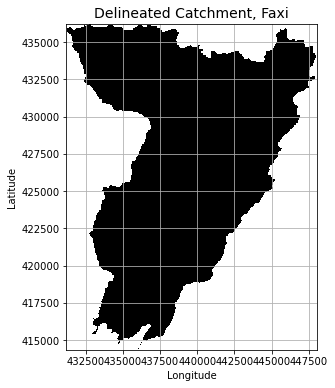

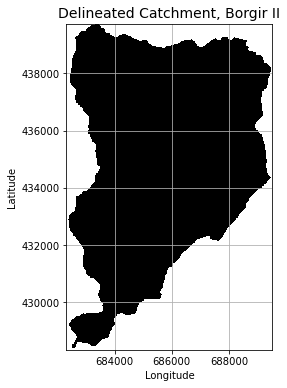

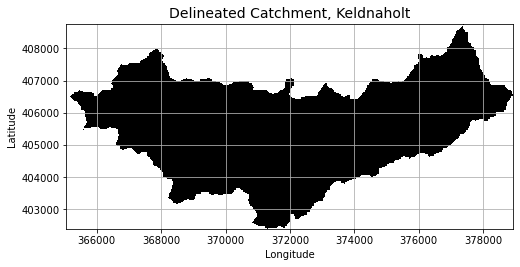

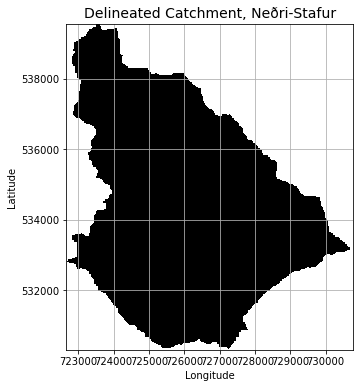

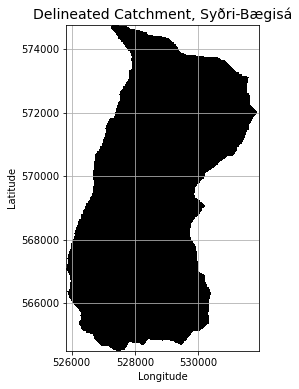

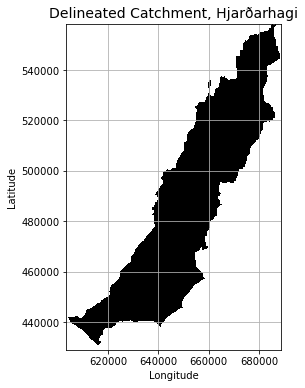

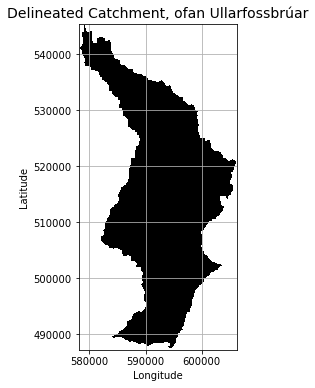

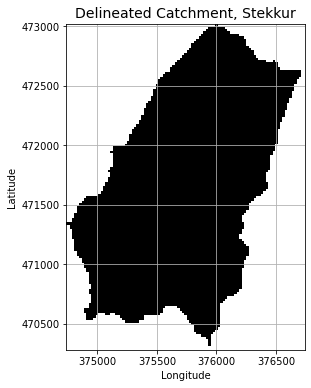

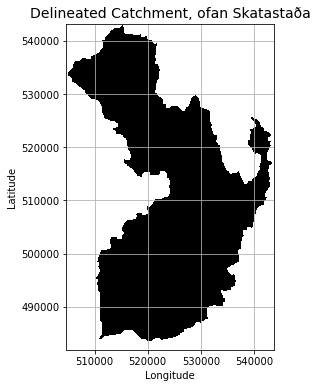

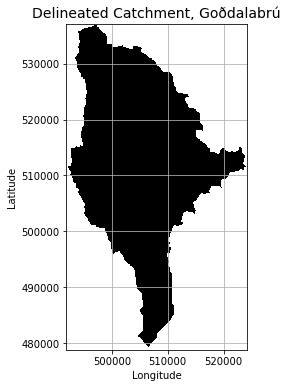

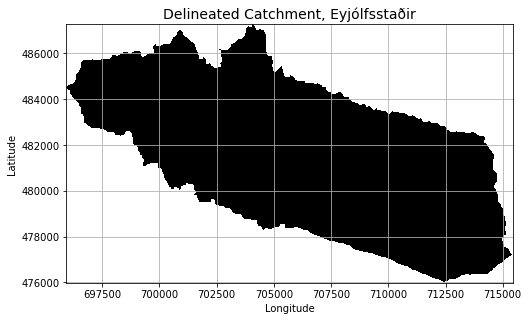

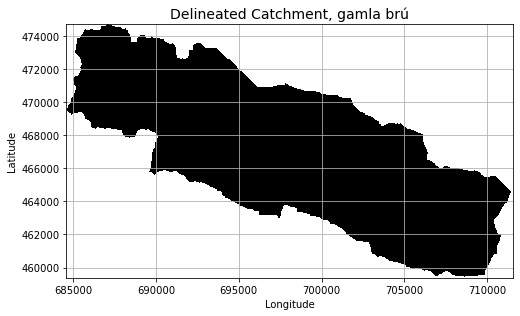

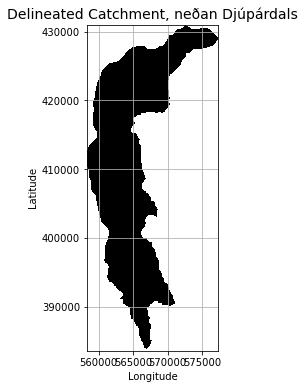

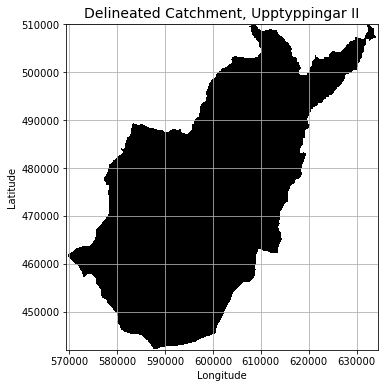

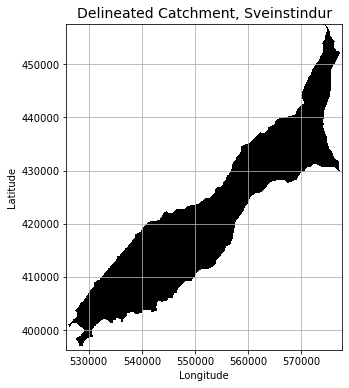

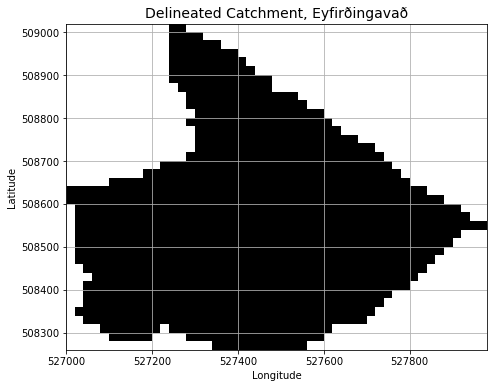

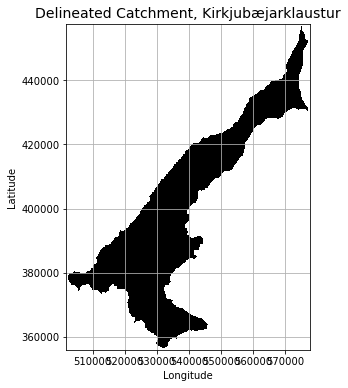

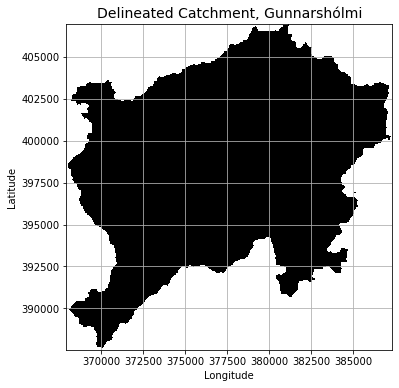

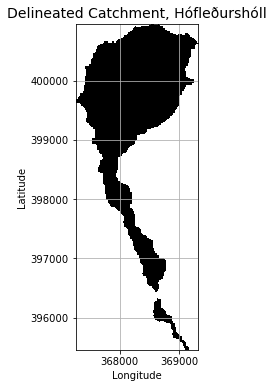

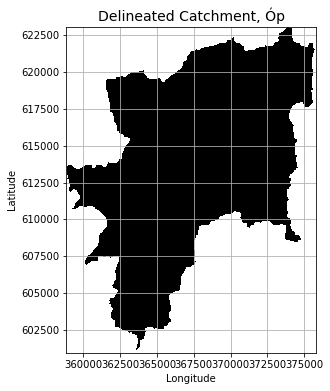

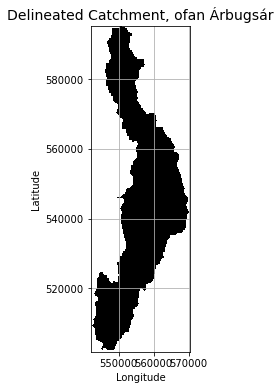

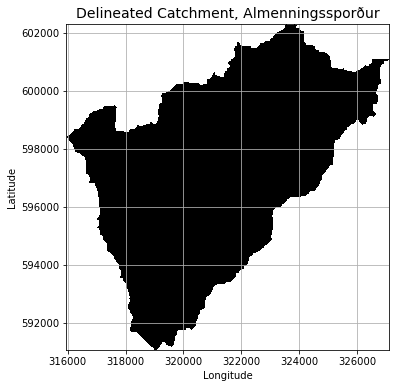

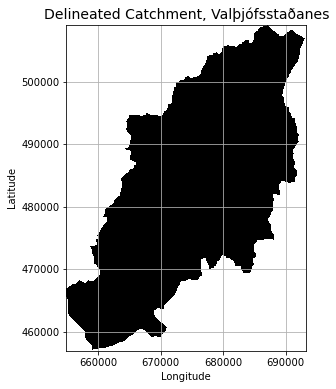

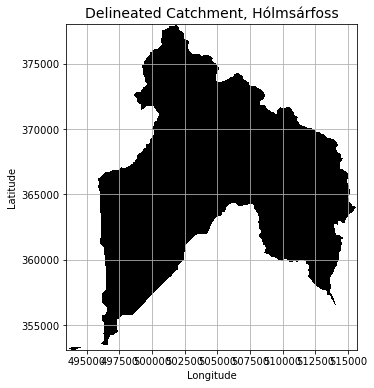

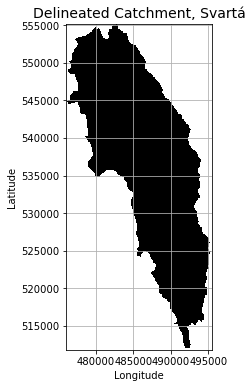

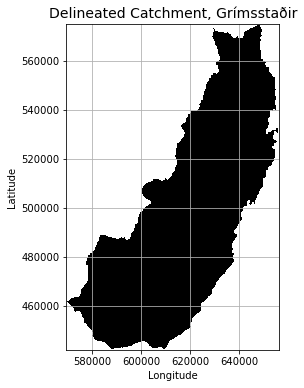

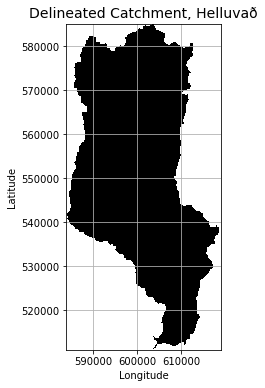

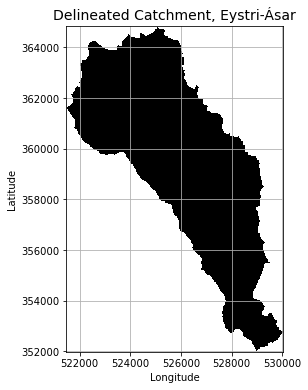

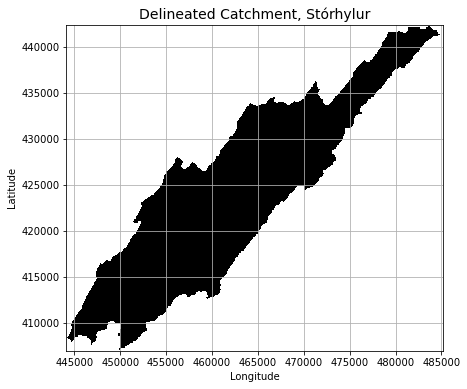

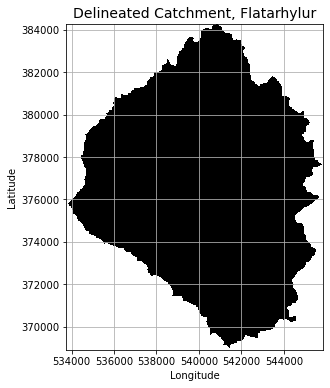

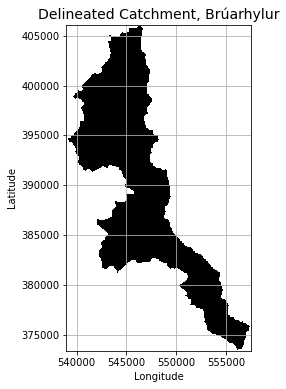

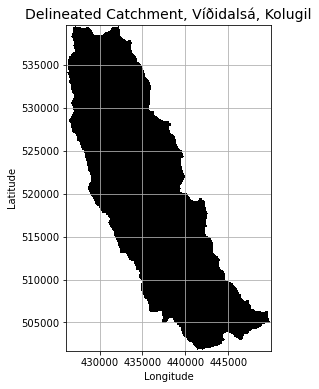

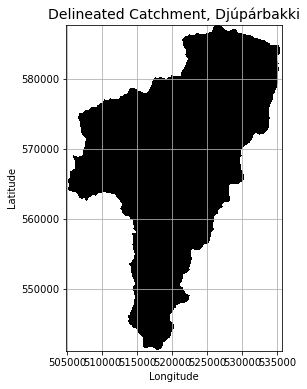

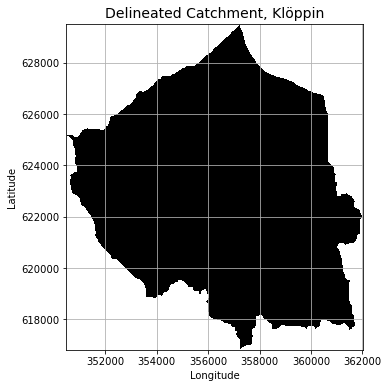

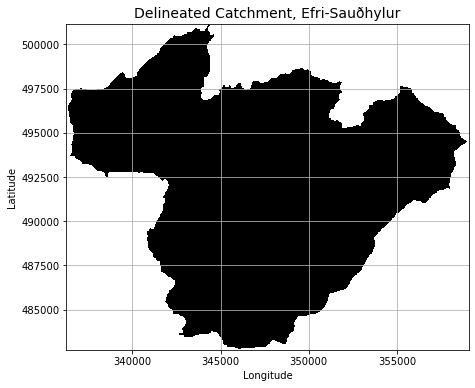

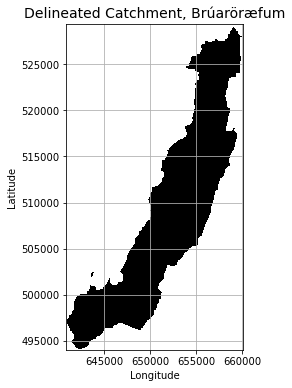

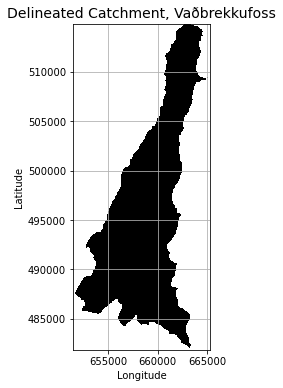

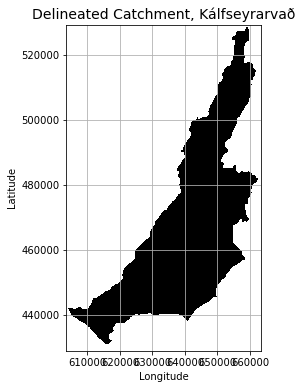

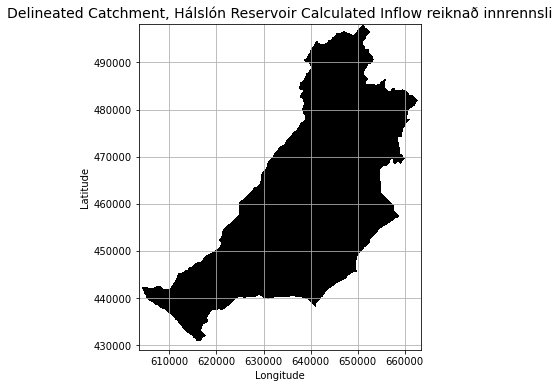

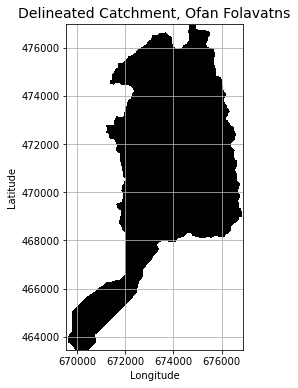

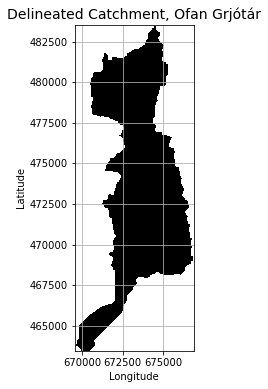

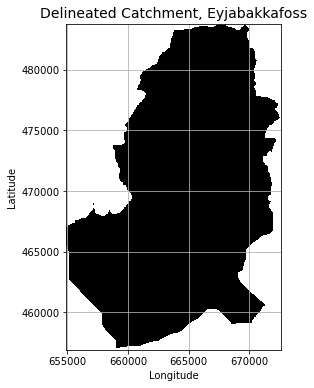

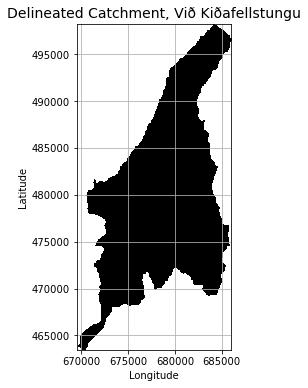

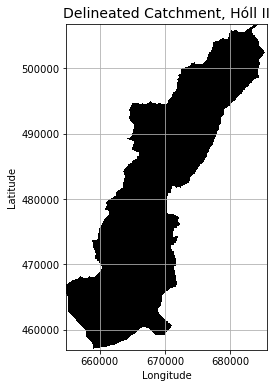

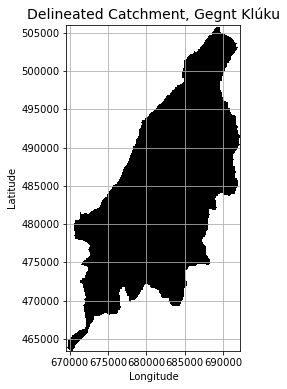

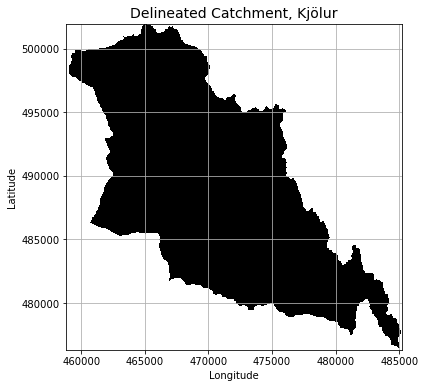

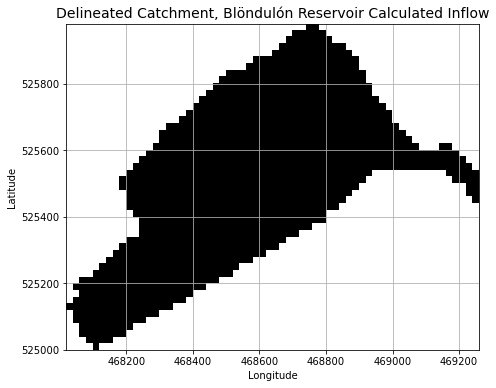

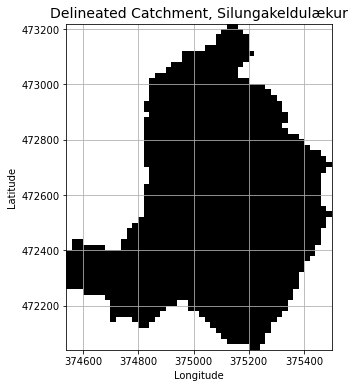

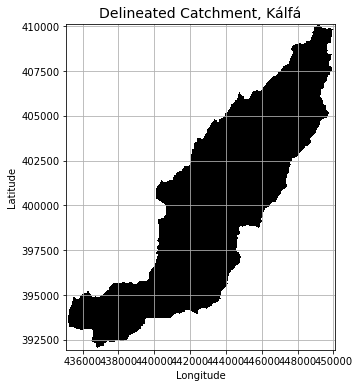

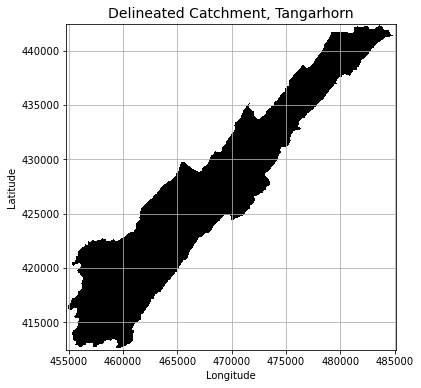

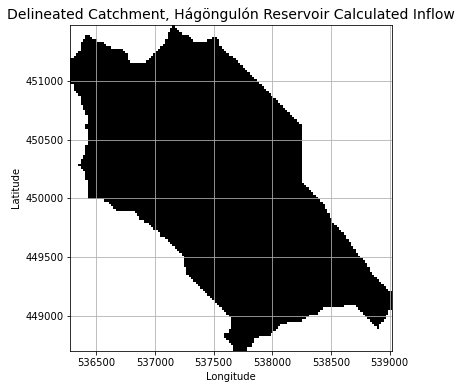

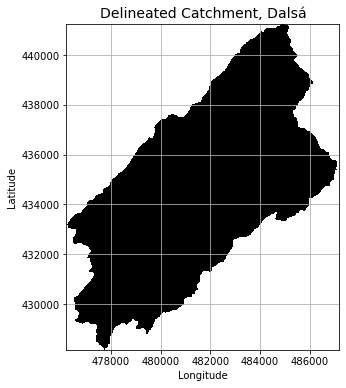

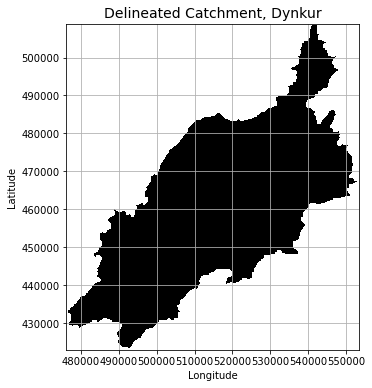

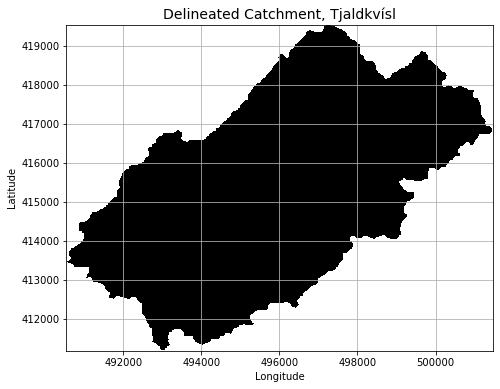

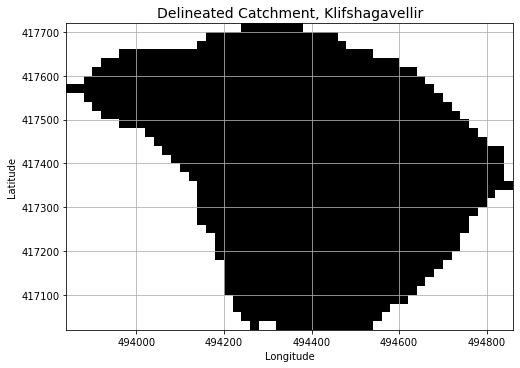

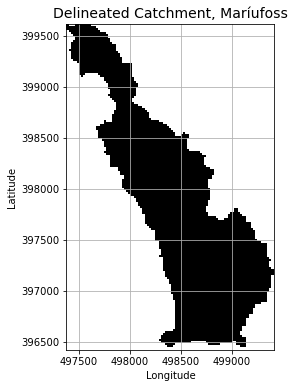

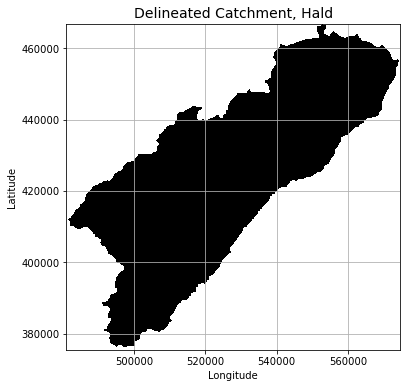

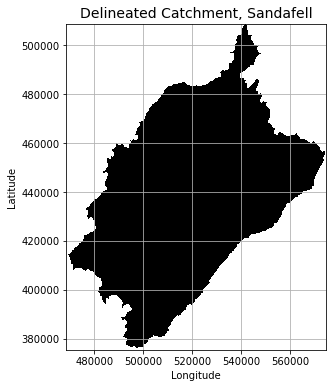

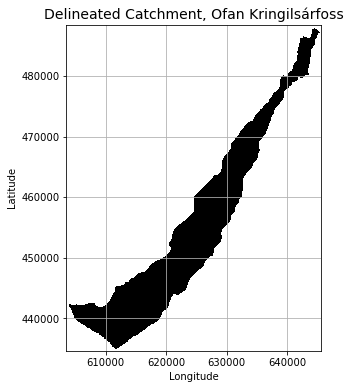

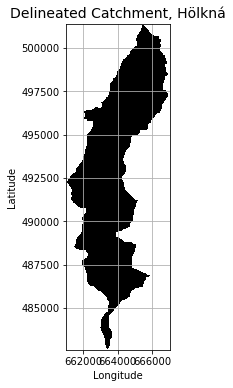

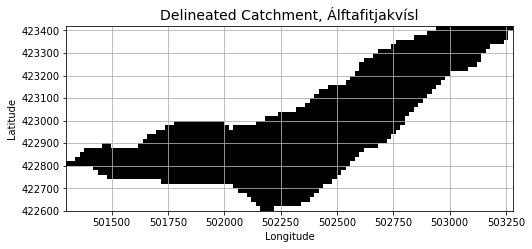

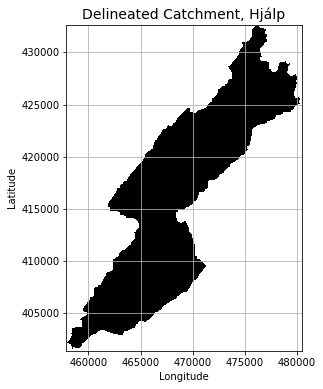

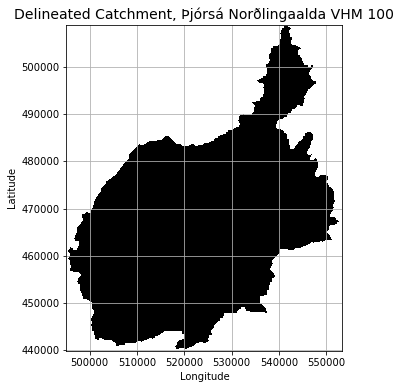

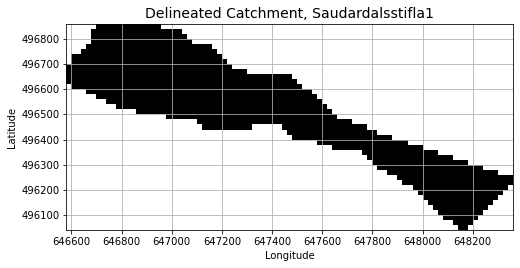

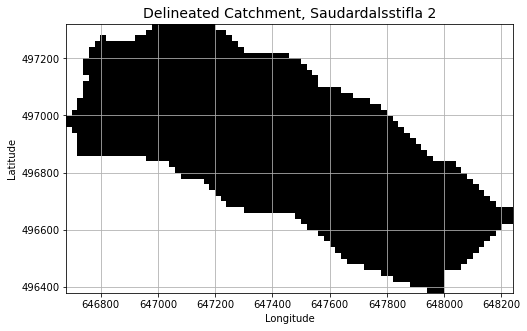

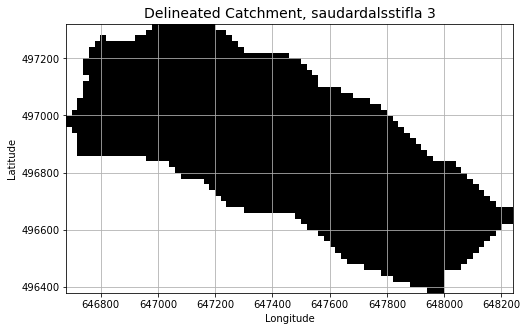

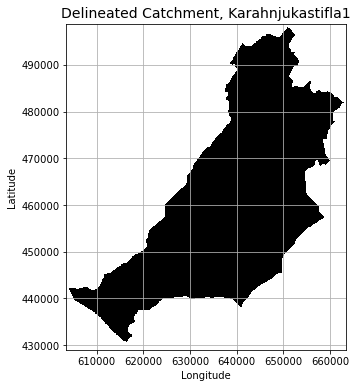

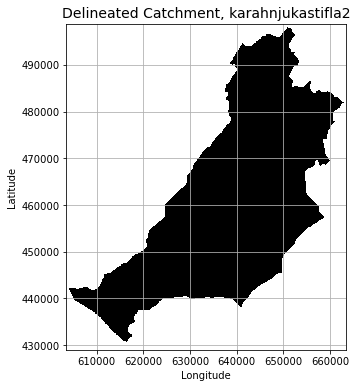

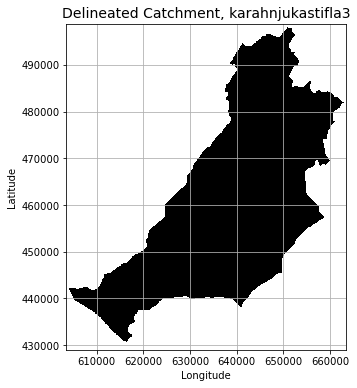

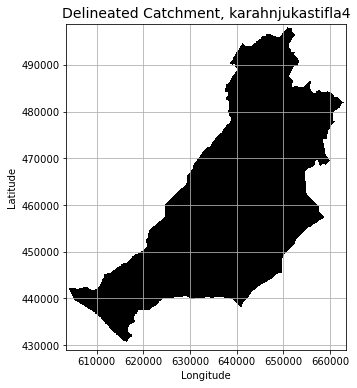

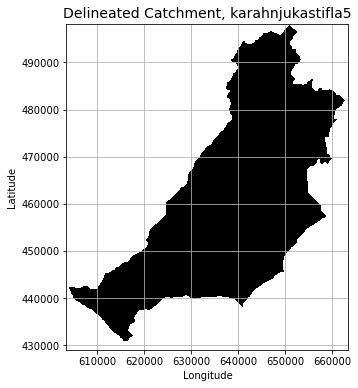

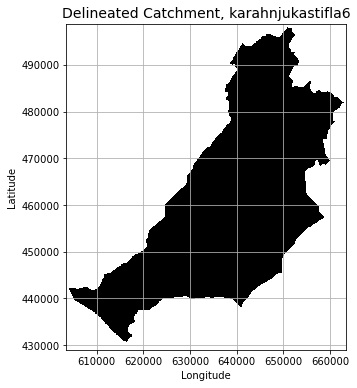

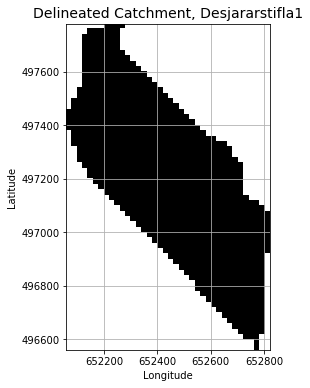

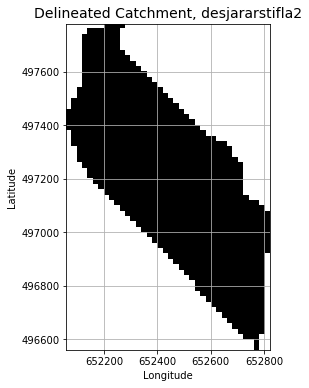

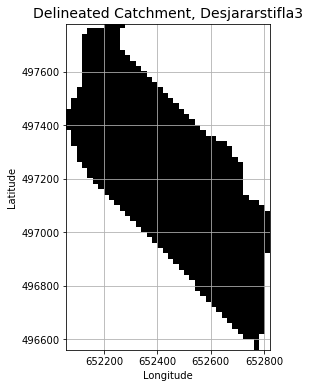

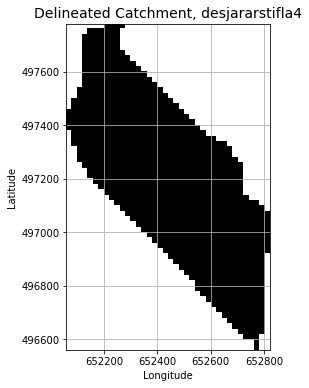

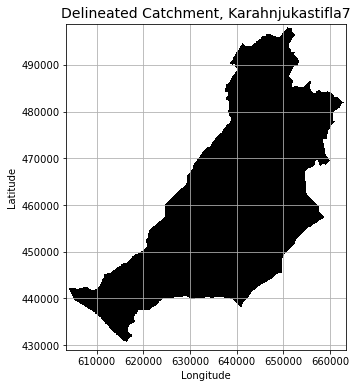

In [79]:
for idx in combined_gauges.index:
    # Reload the grid from the pickled dict
    grid_refreshed = pickle.load( open( "../data/dem/20x20_ISN93_conditioning_output_grid.p", "rb" ) )

    x,y = int(combined_gauges.loc[idx].geometry.x),int(combined_gauges.loc[idx].geometry.y)

    # Delineate a catchment
    # ---------------------

    # Snap pour point to high accumulation cell
    # For a few gauges, we need to bump up the limit
    if combined_gauges.loc[idx]['st_numer'] in ['V128', 'V167', 'V320']:
        x_snap, y_snap = grid_refreshed.snap_to_mask(acc > 1e5, (x, y))
    else:
        x_snap, y_snap = grid_refreshed.snap_to_mask(acc > 1000, (x, y))

    # Delineate the catchment
    catch = grid_refreshed.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                           xytype='coordinate')

    # Crop and plot the catchment
    # ---------------------------
    # Clip the bounding box to the catchment
    grid_refreshed.clip_to(catch)
    clipped_catch = grid_refreshed.view(catch)

    fig, ax = plt.subplots(figsize=(8,6))
    fig.patch.set_alpha(0)

    plt.grid('on', zorder=0)
    im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid_refreshed.extent,
                   zorder=1, cmap='Greys_r')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Delineated Catchment, %s' % combined_gauges.loc[idx]['st_nafn'], size=14)
    plt.show()

    #Export to .shp as demonstrated here: https://github.com/mdbartos/pysheds/blob/master/recipes/write_shapefile.ipynb
    shapes = grid_refreshed.polygonize()

    schema = {
        'geometry': 'Polygon',
        'properties': {'LABEL': 'float:16'}
    }

    with fiona.open('/data/helgason/lamah-ice/gauge_shapefiles/watersheds/combined_gauges_20m/%s.shp' % idx, 'w',
                    driver='ESRI Shapefile',
                    crs=grid_refreshed.crs.srs,
                    schema=schema) as c:
        i = 0
        for shape, value in shapes:
            rec = {}
            rec['geometry'] = shape
            rec['properties'] = {'LABEL' : str(value)}
            rec['id'] = str(i)
            c.write(rec)
            i += 1


In [ ]:
# When delineating watersheds and exporting watershed shapefiles using Pysheds as listed above, 
# some DEM pixels that lie on borders are disconnected from the main polygon. 
# As a post-processing step, we now combine all polygons for each gauge and save the resulting polygon as a new shapefile

In [91]:
for idx in combined_gauges.index:
    path_to_wshed = '/data/helgason/lamah-ice/gauge_shapefiles/watersheds/combined_gauges_20m/%s.shp' % idx
    # Read the watershed shapefile
    wshed = gpd.read_file(path_to_wshed)
    combined = wshed.unary_union
    
    # Define a polygon feature geometry with one attribute
    schema = {
        'geometry': 'Polygon',
        'properties': {'id': 'int'},
    }

    # Write a new Shapefile
    with fiona.open('/data/helgason/lamah-ice/gauge_shapefiles/watersheds/combined_gauges_20m/joined/%s.shp' % idx, 'w', 'ESRI Shapefile', schema) as c:
        ## If there are multiple geometries, put the "for" loop here
        c.write({
            'geometry': mapping(combined),
            'properties': {'id': 123},
        })